In [1]:
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn

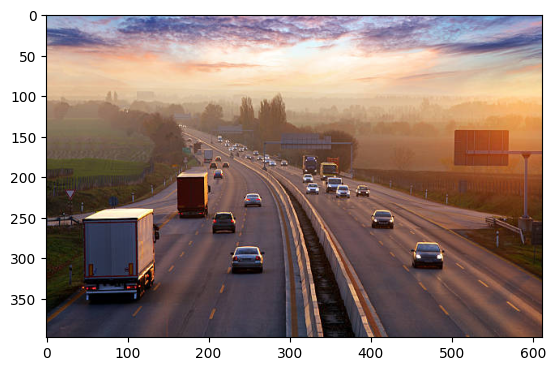

In [2]:
image = cv2.imread('Highway.jpg')

image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.astype(np.float32) / 255.0
plt.imshow(image)

In [7]:
image.shape

(398, 612, 3)

In [8]:
image = torch.from_numpy(image).permute(2,0,1).unsqueeze(0)
image.shape

torch.Size([1, 3, 398, 612])

In [9]:
# import torchvision.transforms.functional as F
# image = F.to_tensor(image).unsqueeze(0)

In [10]:
image.shape

torch.Size([1, 3, 398, 612])

In [11]:
class CNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1
                ):
        super(CNN, self).__init__()
        self.cnn = nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        groups=groups,
        bias=True,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.mish = nn.Mish() # SiLU <-> Swish

    def forward(self, x):
        return self.mish(self.bn(self.cnn(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30884346..14.788712].


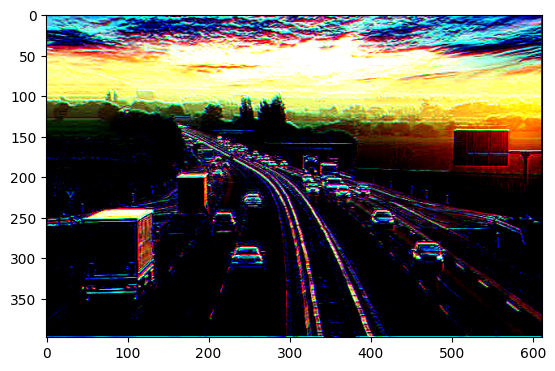

In [12]:
block = CNN(3,3,3,1,1,3)
image_cnn = block(image)
plt.imshow(image_cnn.squeeze(0).permute(1,2,0).detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30884343..14.514722].


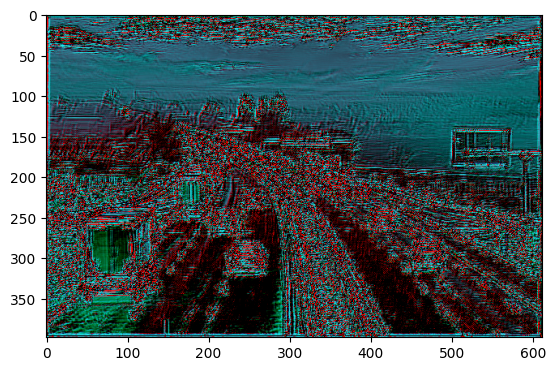

In [13]:
# Define CNN block
class CNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1):
        super(CNN, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=True
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.mish = nn.Mish()  # Mish activation

    def forward(self, x):
        return self.mish(self.bn(self.cnn(x)))

cnn_list = nn.ModuleList()
n = 3
in_channels = 3

# Ascending phase
for i in range(1, n + 1):
    out_channels = in_channels * 2
    cnn_list.append(CNN(in_channels, out_channels, 3, 1, 1, groups=math.gcd(in_channels, out_channels)))
    cnn_list.append(CNN(out_channels, out_channels, 1, groups=1))  # 1x1 convolution should have groups=1
    in_channels = out_channels  # Update

# Descending phase
while in_channels > 3:
    out_channels = max(in_channels // 2, 3)  # Ensure we stop at 3
    cnn_list.append(CNN(in_channels, out_channels, 3, 1, 1, groups=math.gcd(in_channels, out_channels)))
    cnn_list.append(CNN(out_channels, out_channels, 1, groups=1))  # Again, 1x1 conv with groups=1
    in_channels = out_channels  # Update

model = nn.Sequential(*cnn_list)
image_cnn = model(image)
image_cnn.shape
plt.imshow(image_cnn.squeeze(0).permute(1,2,0).detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30884343..19.551172].


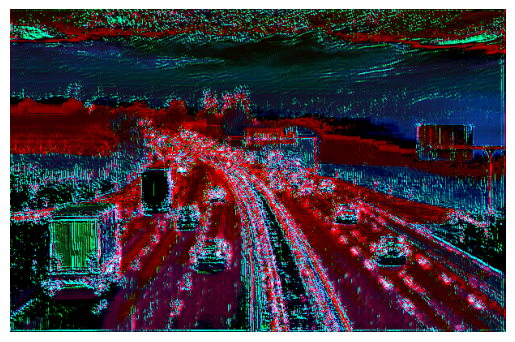

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

# Define CNN block
class CNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1):
        super(CNN, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=True
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.mish = nn.Mish()  # Mish activation

    def forward(self, x):
        return self.mish(self.bn(self.cnn(x)))

# Define the full model with flexible kernel size
class RepInspiredCNN(nn.Module):
    def __init__(self, n=3, input_channels=3,padding=1, kernel_size=3):
        super(RepInspiredCNN, self).__init__()
        layers = nn.ModuleList()
        self.in_channels = input_channels

        # Ascending phase
        for _ in range(n):
            out_channels = self.in_channels * 2
            layers.append(CNN(self.in_channels, out_channels, kernel_size, 1, padding, groups=math.gcd(self.in_channels, out_channels)))
            layers.append(CNN(out_channels, out_channels, 1, groups=1))  # Pointwise conv
            self.in_channels = out_channels

        # Descending phase
        while self.in_channels > input_channels:
            out_channels = max(self.in_channels// 2, input_channels)
            layers.append(CNN(self.in_channels, out_channels, kernel_size, 1, padding, groups=math.gcd(self.in_channels, out_channels)))
            layers.append(CNN(out_channels, out_channels, 1, groups=1))  # Pointwise conv
            self.in_channels = out_channels

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


# Use 5x5 convolutions instead of 3x3
model = RepInspiredCNN(n=3, input_channels=3, kernel_size=1, padding= 0)
image_cnn1 = model(image)

model = RepInspiredCNN(n=3, input_channels=3, kernel_size=3, padding= 1)
image_cnn2 = model(image)

image_cnn = torch.cat([image_cnn1, image_cnn2, image], 1)

trans = CNN(9,3,1)

image_cnn =  trans(image_cnn)              #torch.cat([image_cnn1, image_cnn2],1)


# # Normalize for display
image_cnn = image_cnn.squeeze(0).permute(1, 2, 0).detach().numpy()
#image_cnn = (image_cnn - image_cnn.min()) / (image_cnn.max() - image_cnn.min())  # Normalize to [0,1]

# Show image
plt.imshow(image_cnn)
plt.axis("off")
plt.show()


In [15]:
x = image.clone()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5414281..52.360443].


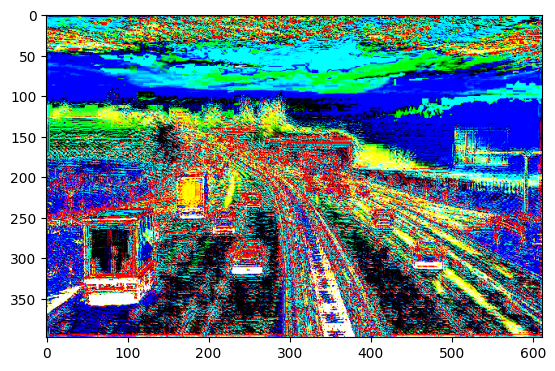

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math


class CNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1):
        super(CNN, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=True
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.mish = nn.Mish()  # Mish activation

    def forward(self, x):
        return self.mish(self.bn(self.cnn(x)))

# Define the full model with flexible kernel size
class RepInspiredCNN(nn.Module):
    def __init__(self, n=3, input_channels=3,padding=1, kernel_size=3):
        super(RepInspiredCNN, self).__init__()
        layers = nn.ModuleList()
        self.in_channels = input_channels

        # Ascending phase
        for _ in range(n):
            out_channels = self.in_channels * 2
            layers.append(CNN(self.in_channels, out_channels, kernel_size, 1, padding, groups=math.gcd(self.in_channels, out_channels)))
            layers.append(CNN(out_channels, out_channels, 1, groups=1))  # Pointwise conv
            self.in_channels = out_channels

        # Descending phase
        while self.in_channels > input_channels:
            out_channels = max(self.in_channels// 2, input_channels)
            layers.append(CNN(self.in_channels, out_channels, kernel_size, 1, padding, groups=math.gcd(self.in_channels, out_channels)))
            layers.append(CNN(out_channels, out_channels, 1, groups=1))  # Pointwise conv
            self.in_channels = out_channels

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class RepSequenceBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, reduction=1):
        super(RepSequenceBlock, self).__init__()

        # 1️⃣ Dynamic Kernel Generation (Using a Small Network)
        self.kernel_gen = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global Context
            nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1),  # Reduce Dim
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels* kernel_size * kernel_size, kernel_size=1),  # Expand to Kernel Weights
            nn.Sigmoid()  # Normalize to [0,1]
        )

        # 2️⃣ Standard Depthwise Convolution (Dynamic Kernels)
        self.con1x1 = RepInspiredCNN(n=3, input_channels=3, kernel_size=1, padding= 0)
        self.con3X3 = RepInspiredCNN(n=3, input_channels=3, kernel_size=3, padding= 1)

        self.transition = CNN(self.con3X3.in_channels + self.con1x1.in_channels +  self.con1x1.in_channels, self.con3X3.in_channels, 1)

    def forward(self, x):
        batch, channels, height, width = x.shape
        
        # Generate dynamic kernel weights
        kernel_weights = self.kernel_gen(x)  # Shape: (B, C*K*K, 1, 1)
        kernel_weights = kernel_weights.view(batch, channels, 3, 3)  # Reshape for 3x3 Kernel
        
        # Ensure the kernel_weights have the correct shape for broadcasting
        kernel_weights = kernel_weights.unsqueeze(2).unsqueeze(3)  # Shape: (B, C, 1, 1, 3, 3)

        # Broadcast the kernel weights to match the output dimensions (B, C, H, W)
        kernel_weights = kernel_weights.expand(-1, -1, height, width, -1, -1)  # Shape: (B, C, H, W, 3, 3)

        # Apply dynamic modulation (this needs to be done properly for each output pixel)
        # Convolve using depthwise convolution
        out = torch.cat([self.con1x1(x), self.con3X3(x), x], 1)  # Apply depthwise convolution
        out = self.transition(out)
        
        out = out * kernel_weights.sum(dim=[4, 5])
        
        return out

# Example usage
#x = torch.randn(1, 3, 32, 32)  # Batch=1, 3 channels, 32x32 image
model = RepSequenceBlock(in_channels=3, out_channels=3)
output = model(x)
output = output.squeeze(0).permute(1, 2, 0).detach().numpy()
plt.imshow(output)

In [17]:
output.shape

(398, 612, 3)

In [18]:
model

RepSequenceBlock(
  (kernel_gen): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (2): ReLU()
    (3): Conv2d(3, 27, kernel_size=(1, 1), stride=(1, 1))
    (4): Sigmoid()
  )
  (con1x1): RepInspiredCNN(
    (model): Sequential(
      (0): CNN(
        (cnn): Conv2d(3, 6, kernel_size=(1, 1), stride=(1, 1), groups=3)
        (bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (mish): Mish()
      )
      (1): CNN(
        (cnn): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (mish): Mish()
      )
      (2): CNN(
        (cnn): Conv2d(6, 12, kernel_size=(1, 1), stride=(1, 1), groups=6)
        (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (mish): Mish()
      )
      (3): CNN(
        (cnn): Conv2d(12, 12, kernel_size=(1, 1), stride=(

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4398654..44.82566].


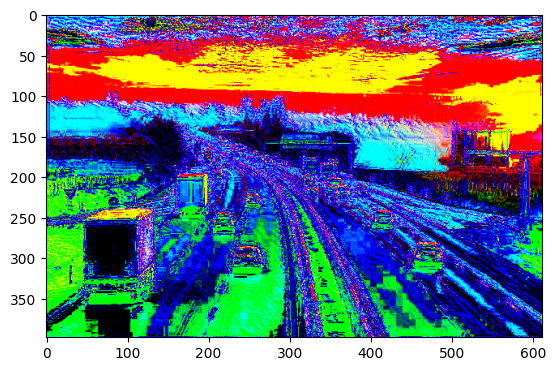

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

class CNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1):
        super(CNN, self).__init__()
        self.cnn = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=True)
        self.bn = nn.BatchNorm2d(out_channels)
        self.mish = nn.Mish()  # Mish activation

    def forward(self, x):
        return self.mish(self.bn(self.cnn(x)))

class RepInspiredCNN(nn.Module):
    def __init__(self, n=3, input_channels=3, padding=1, kernel_size=3):
        super(RepInspiredCNN, self).__init__()
        layers = nn.ModuleList()
        self.in_channels = input_channels

        # Ascending phase
        for _ in range(n):
            out_channels = self.in_channels * 2
            layers.append(CNN(self.in_channels, out_channels, kernel_size, 1, padding, groups=math.gcd(self.in_channels, out_channels)))
            layers.append(CNN(out_channels, out_channels, 1, groups=1))  # Pointwise conv
            self.in_channels = out_channels

        # Descending phase
        while self.in_channels > input_channels:
            out_channels = max(self.in_channels // 2, input_channels)
            layers.append(CNN(self.in_channels, out_channels, kernel_size, 1, padding, groups=math.gcd(self.in_channels, out_channels)))
            layers.append(CNN(out_channels, out_channels, 1, groups=1))  # Pointwise conv
            self.in_channels = out_channels

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class RepSequenceBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, reduction=1, n= 1):
        super(RepSequenceBlock, self).__init__()

        # Dynamic Kernel Generation
        self.kernel_gen = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global Context
            nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1),  # Reduce Dim
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels * kernel_size * kernel_size, kernel_size=1),  # Expand to Kernel Weights
            nn.Sigmoid()  # Normalize to [0,1]
        )

        # Depthwise Convolutions
        self.con1x1 = RepInspiredCNN(n=n, input_channels=in_channels, kernel_size=1, padding=0)
        self.con3x3 = RepInspiredCNN(n=n, input_channels=in_channels, kernel_size=3, padding=1)

        self.transition = CNN(
            self.con3x3.in_channels + self.con1x1.in_channels + in_channels, 
            out_channels, 
            1
        )

    def forward(self, x):
        batch, channels, height, width = x.shape

        # Generate dynamic kernel weights
        kernel_weights = self.kernel_gen(x).view(batch, channels, 3, 3)  # Reshape for 3x3 Kernel
        kernel_weights = kernel_weights.unsqueeze(2).unsqueeze(3)  # (B, C, 1, 1, 3, 3)
        kernel_weights = kernel_weights.expand(-1, -1, height, width, -1, -1)  # (B, C, H, W, 3, 3)

        # Apply convolutions
        out = torch.cat([self.con1x1(x), self.con3x3(x), x], 1)
        out = self.transition(out)

        # Dynamic kernel modulation
        out = out * kernel_weights.sum(dim=[4, 5])
        return out


model = RepSequenceBlock(in_channels=3, out_channels=3, n= 3)
output = model(x)
output = output.squeeze(0).permute(1, 2, 0).detach().numpy()

# Display the output
plt.imshow(output)
plt.show()


In [20]:
n = 3
result = []
for i in range(1, n + 1):
        result.append(i)
    
# Descending sequence
for i in range(n - 1, 0, -1):
    result.append(i)
result

[1, 2, 3, 2, 1]

In [21]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, n= 3):
        super(Block, self).__init__()

        self.m = nn.Sequential(*[RepSequenceBlock(in_channels=in_channels//2, out_channels=in_channels//2, n = n) for _ in range(n)]) 
        self.con1X1 = CNN(in_channels=in_channels//2, out_channels=in_channels//2, kernel_size=1)
        self.con1 = CNN(in_channels=in_channels, out_channels=in_channels, kernel_size=1)
    def forward(self, x):
        x1, x2 = x.chunk(2,1)
        x1 = self.con1X1(x1)
        x2 = self.con1X1(x2)
        x1 = self.m(x1)
        x = torch.cat([x1, x2], dim=1)
        x = self.con1(x)
        return x
        
        

In [22]:
x = torch.randn(1,32,224,224)
model = Block(32,32,n=3)

out = model(x)
out.shape

torch.Size([1, 32, 224, 224])

In [24]:
class C3K2(nn.Module):
    def __init__(self, in_channels, out_channels, n= 3):
        super(C3K2, self).__init__()
        self.con1X1 = CNN(in_channels=in_channels//2, out_channels=in_channels//2, kernel_size=1)
        self.m = Block(in_channels//2,in_channels//2,n=3)
        self.transition = CNN(in_channels=in_channels//2 * 5, out_channels=in_channels, kernel_size=1)
    def forward(self, x):
        x1, x2 = x.chunk(2,1)
        x1 = self.con1X1(x1)
        x2 = self.con1X1(x2)
        x3 = self.m(x2)
        x4 = self.m(x3)
        x5 = self.m(x4)
        x6 = torch.cat([x1, x2, x3, x4, x5], 1)
        x7 = self.transition(x6)
        return x7

In [47]:
x = torch.randn(1,32,224,224)
model = C3K2(32,32,n=4)

out = model(x)
out.shape

torch.Size([1, 32, 224, 224])

In [49]:
x = image.clone()

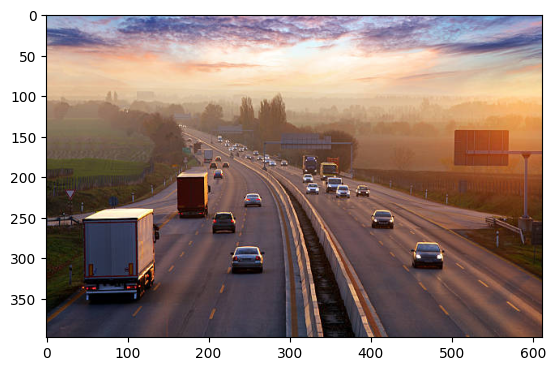

In [39]:
x1, x2 = x.chunk(2,1)
plt.imshow(torch.cat([x1, x2], 1).squeeze(0).permute(1, 2, 0).detach().numpy())

In [57]:
model = RepSequenceBlock(in_channels=32, out_channels=32, n= 3)
x = torch.randn(1,32,224,224)
output = model(x)
output.shape

torch.Size([1, 32, 224, 224])

In [40]:
import natten

In [4]:
import torch
from natten import NeighborhoodAttention2D as NeighborhoodAttention

# Correct input shape: (batch_size, channels, height, width)
x = torch.randn(1,124 , 128 )  # NCHW

# Correct argument order: dim, kernel_size, num_heads
attn = NeighborhoodAttention(dim=320, kernel_size=7, num_heads=2, dilation=1)

# # # Forward pass
# output = attn(x)
# print(output.shape)



In [5]:
# Count total parameters
total_params = sum(p.numel() for p in attn.parameters())
print(f"Total parameters: {total_params}")

# Count only trainable parameters
trainable_params = sum(p.numel() for p in attn.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Total parameters: 410880
Trainable parameters: 410880


In [6]:
attn = NeighborhoodAttention(
            3,
            kernel_size=7,
            dilation=1,
            num_heads=3,
            qkv_bias=True,
            qk_scale=False,
            attn_drop=0.0,
            proj_drop=0.0
        )

In [7]:
attn(x).shape

ValueError: NeighborhoodAttention2D expected a rank-4 input tensor; got x.dim()=3.

In [2]:
import torch

In [10]:
import torch.nn as nn
x = torch.randn(1, 224, 224, 1024)
na2d = NeighborhoodAttention(dim=1024, kernel_size=7, dilation=2, num_heads=1)

# Move to multiple GPUs
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(na2d)

# Move to GPU
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = na2d.to(device)

Using 2 GPUs!


In [55]:
x = torch.randn(1, 224, 224, 1024)
na2d = NeighborhoodAttention(dim=1024, kernel_size=7, dilation=2, num_heads=1)

In [56]:
na2d(x).shape

torch.Size([1, 224, 224, 1024])

In [122]:
120/3

40.0

In [ ]:
import natten
from natten import NeighborhoodAttention2D as NeighborhoodAttention

class NATransformerLayer(nn.Module):
    def __init__(
        self,
        dim,
        num_heads,
        kernel_size=7,
        dilation=1,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        act_layer=nn.Mish(),
        norm_layer=nn.LayerNorm,
        **kwargs
    ):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.mlp_ratio = mlp_ratio

        self.norm1 = norm_layer(dim)
        self.attn = NeighborhoodAttention(
            dim,
            kernel_size=kernel_size,
            dilation=dilation,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop=attn_drop,
            proj_drop=drop,
             **kwargs,
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(
            in_features=dim,
            hidden_features=mlp_hidden_dim,
            out_features=dim,
            p=drop,
        )

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x)
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

In [3]:
import torch
x = torch.randn(1,3,224,224)



device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
x.to(device)

tensor([[[[-0.6181, -0.1503,  0.2171,  ...,  0.5819, -1.6915,  0.0393],
          [-0.5903,  0.8168,  1.6561,  ...,  0.8115, -0.0310,  0.9559],
          [ 1.0844,  0.9421,  1.0466,  ...,  2.0919, -0.5792,  0.4703],
          ...,
          [ 2.2025, -0.5388, -0.7443,  ..., -1.0021, -0.5880,  0.2861],
          [-0.4813,  0.3255,  0.3396,  ...,  0.3122, -0.1162, -1.6564],
          [ 0.0740,  0.4436,  1.0510,  ...,  0.4169,  0.8019,  1.2924]],

         [[-1.3311,  0.0295,  0.4268,  ..., -0.0324,  1.4489,  0.6034],
          [ 0.0819, -0.0271, -0.2055,  ..., -0.3568,  0.2934, -0.8612],
          [-0.7309, -1.1513,  0.4767,  ..., -3.3591,  1.7907,  0.1082],
          ...,
          [-0.8772,  0.0234, -0.6672,  ..., -0.5908,  0.0271,  2.3114],
          [-1.2244, -0.2962,  0.3860,  ...,  0.0410,  1.0800,  1.4682],
          [-0.2150, -1.7726,  0.9529,  ..., -0.7171, -0.8950, -0.8136]],

         [[ 1.5686,  0.3170,  0.1782,  ..., -1.0267,  0.4222,  0.1768],
          [ 0.9543,  0.1368, -

In [61]:
x.to(device)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [5]:
import torch
torch.cuda.device_of

TypeError: device_of.__init__() missing 1 required positional argument: 'obj'